## 0. Setups

In [2]:
# system and misc
import os
import time
import sys

# data manipulation and visualization
import numpy as np
import pandas
import matplotlib.pyplot as plt

# image processing
from skimage import io, transform, exposure
import albumentations as Alb
import tifffile

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

## 1. Configuration

In [71]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """

    # ============== Model Configuration =============
    MODEL_NAME = 'Attention Unet'
    BACKBONE = 'se_resnext50_32x4d'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (1024, 1024)  # Size of the input images (height x width)
    GAMMA = 3 # Gamma correction for image preprocessing

    # =============
    # = Training and Validation Parameters =============
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Device to use for training
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 16  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    NUM_WORKERS = 0 # Number of threds
    TRAIN_TEST_SPLIT_RATIO = 0.2  # for test subset

    # ============== Model Paths =============
    # List of paths to trained model weights
    MODEL_PATHS = [
        "/path/to/model1.pt",
        "/path/to/model2.pt",
        # Add more model paths as needed
    ]

    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = os.path.join(".", "blood-vessel-segmentation")
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

## 2. Load Dataset

### 2,1 Custom Dataset Class

In [72]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mask_path=None, target_image_size=(512, 512), convert_size=True, gamma=1, image_format=".tif"):
        # File IO
        self.image_path = image_path
        self.image_format = image_format
        self.image_filenames = sorted([os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith(self.image_format)])
        print(f"{len(self.image_filenames)} samples are loaded.")

        # If masks (labels) are given
        self.mask_path = mask_path
        if self.mask_path:
            self.mask_filenames = sorted([os.path.join(self.mask_path, filename) for filename in os.listdir(self.mask_path) if filename.endswith(self.image_format)])
            if not len(self.mask_filenames) == len(self.image_filenames):
                raise(f"Number of images and labels are not matched: {len(self.image_filenames)} images and {len(self.mask_filenames)} labels.")
            print(f"{len(self.mask_filenames)} labels are loaded.")
        
        # Image processing
        self.target_image_size = target_image_size
        self.convert_size = convert_size
        self.gamma = gamma

        # Process and print the size of the first image if convert_size is True
        if self.convert_size and len(self.image_filenames) > 0:
            first_image = io.imread(self.image_filenames[0])
            resized_image = self.resize_and_pad(first_image, self.target_image_size)
            print(f"Original size: {first_image.shape}, Converted size: {resized_image.shape}")

    def __getitem__(self, index):
        # Load image
        image = io.imread(self.image_filenames[index])

        # Resize and pad the image if convert_size is True
        if self.convert_size:
            image = self.resize_and_pad(image, self.target_image_size)
        
        # Extract the filename
        image_filename = os.path.basename(self.image_filenames[index])
        
        # If masks (labels) are given
        if self.mask_path:
            mask = io.imread(self.mask_filenames[index])
            mask = self.resize_and_pad(mask, self.target_image_size, gamma=1) # mask containing 0s and 1s only.
            return image, mask, image_filename
        
        return image, image_filename

    def __len__(self):
        return len(self.image_filenames)

    def resize_and_pad(self, image, target_image_size, gamma=3):
        """Resize an image, apply gamma correction, and add padding to keep aspect ratio."""
        # Calculate scale and padding
        h, w = image.shape[:2]
        scale = min(target_image_size[0] / h, target_image_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        pad_h = (target_image_size[0] - new_h) // 2
        pad_w = (target_image_size[1] - new_w) // 2

        # Resize image with 'constant' mode to keep original pixel values
        image_resized = transform.resize(
            image, 
            (new_h, new_w), 
            mode='constant', 
            anti_aliasing=True, 
            preserve_range = True, # preserve the original image's intensity range
            order=1
        )

        # Apply gamma correction to adjust brightness
        if not self.gamma == 1:
            image_resized = exposure.adjust_gamma(image_resized, gamma)

        # Add a channel dimension to grayscale images if necessary
        if len(image.shape) == 2:  # Grayscale image
            image_resized = image_resized[..., np.newaxis]

        # Initialize padded image
        padded_image = np.zeros((target_image_size[0], target_image_size[1], image_resized.shape[2]), dtype=image_resized.dtype)

        # Insert the resized and adjusted image into the padded image
        padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w, :] = image_resized

        return padded_image

### 2.2 Display Function

In [73]:
def display_image(images, titles=None, max_cols=4):
    # Wrap single image in a list
    if not isinstance(images, list):
        images = [images]
        titles = [titles] if titles is not None else titles

    if titles is not None and not isinstance(titles, list):
        raise TypeError("Titles should be provided as a list or a single title for a single image.")

    if titles and len(images) != len(titles):
        raise ValueError("Every image should have a corresponding title.")

    num_images = len(images)
    cols = min(num_images, max_cols)
    rows = num_images // cols + (num_images % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    if rows == 1 or cols == 1:
        axes = np.array([axes])

    axes = axes.flatten()[:num_images]  # Limit to the number of images to avoid blank subplots

    for ax, img, title in zip(axes, images, titles or [None]*num_images):
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.ndim == 3 and img.shape[0] in [1, 3, 4]:
                img = img.transpose(1, 2, 0)
            if img.ndim == 3 and img.shape[2] == 1:
                img = img.squeeze(2)

        ax.imshow(img, cmap='gray')
        if title:
            ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### 2.3 Load Dataset and Display Sample Image

In [74]:
image_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images")
mask_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels")
dataset = CustomDataset(image_path, mask_path, target_image_size=CFG.INPUT_IMAGE_SIZE, gamma=CFG.GAMMA)

2279 samples are loaded.
2279 labels are loaded.
Original size: (1303, 912), Converted size: (1024, 1024, 1)


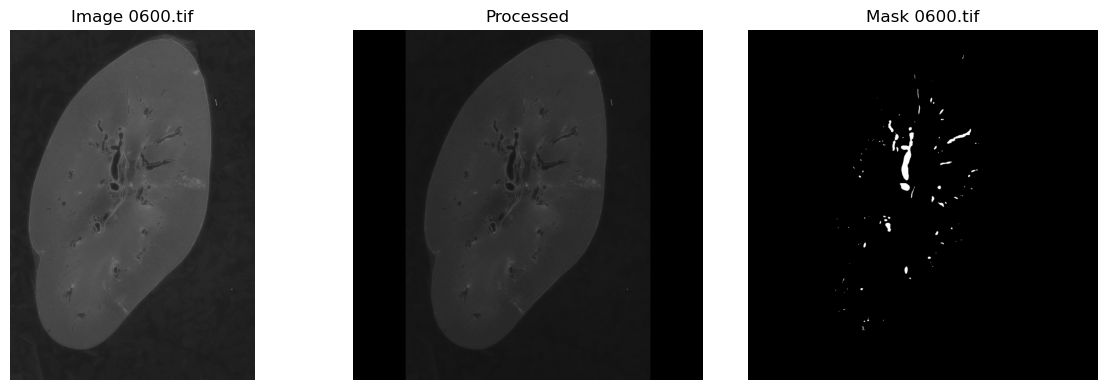

In [75]:
index = 600
original_image = io.imread(os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images", dataset[index][2]))
display_image([original_image, dataset[index][0], dataset[index][1]], [f"Image {dataset[index][2]}", "Processed", f"Mask {dataset[index][2]}"])

### 2.4 Train-Test-Split and DataLoader

In [76]:
# Calculate the sizes of train and test sets
total_size = len(dataset)
test_size = int(total_size * CFG.TRAIN_TEST_SPLIT_RATIO)
train_size = total_size - test_size

# Randomly split the dataset into train and test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Now you can create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

## 3. Image Augmentation

In [77]:
def Augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]
    
    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])   
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    # Making the mask dimentions 3
    for i in range(4):
        if mask_list[i].ndim == 2:
            mask_list[i] = mask_list[i][..., np.newaxis]

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip

## 4. RLE Encoding & Decoding

In [78]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle == '':
        rle = '1 0'
    return rle

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

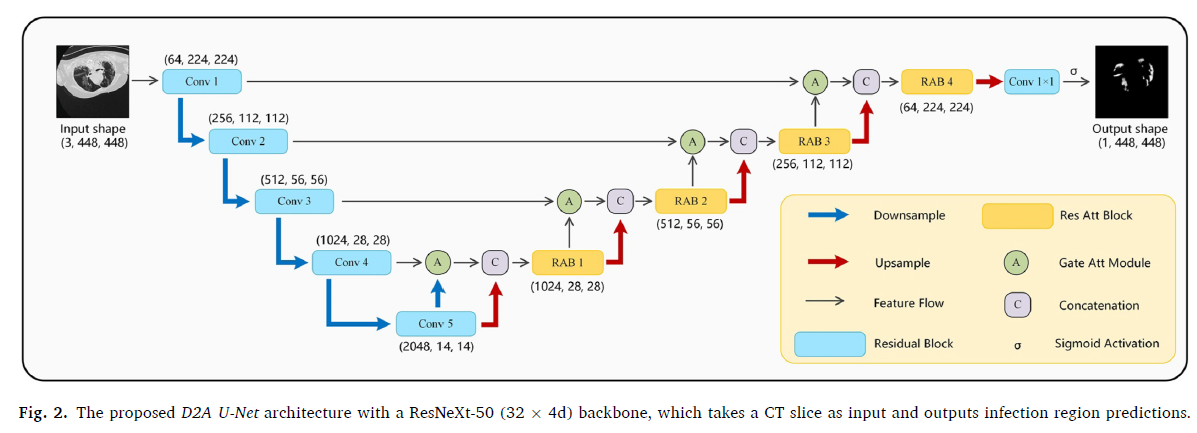

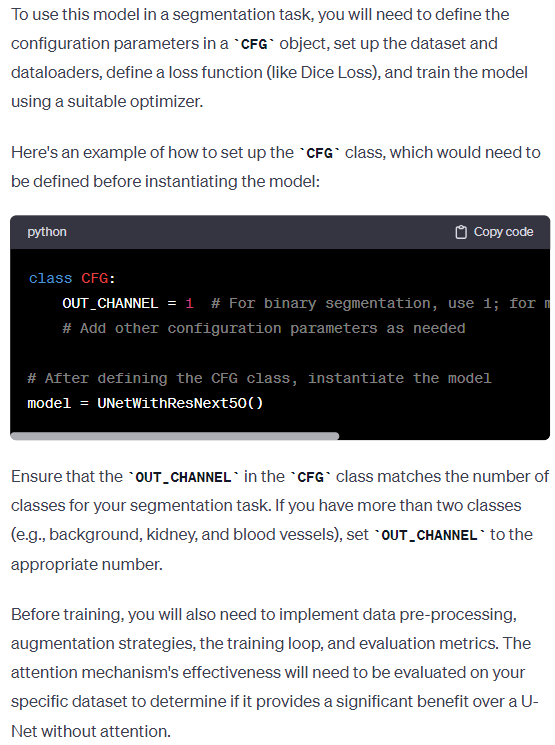

## 5. Surface DICE Loss Function

after each epoch or a set number of training iterations, you would run a validation loop where you use your model to predict the masks on the validation dataset. These predictions would then be compared to the ground truth masks using the surface dice metric. 

### Attention U-Net ResNext50 32x4d

In [79]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        # Defines the first convolution layer with batch normalization
        # kernel_size = (3, 3) means 3x3 filter (common choice in CNNs)
        # padding = 1 means single layer of zeros is added around the image
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), padding=1) 
        self.bn1 = nn.BatchNorm2d(out_channel)

        # Defines the ReLU activation function
        self.relu = nn.ReLU()

        # Defines the second convolution layer with batch normalization
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, inputs):
        # Applies the first convolution, batch normalization, and ReLU
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        # Applies the second convolution, batch normalization, and ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder Block """
""" contains a ConvBlock for feature extraction and a max pooling layer to 
    reduce the spatial dimensions of the feature maps, thereby increasing the receptive field of network. """
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        # Instantiates a ConvBlock for encoding and a MaxPooling layer
        self.conv = ConvBlock(in_channel, out_channel)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), padding=0)

    def forward(self, inputs):
        # Applies ConvBlock and then MaxPooling
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder Block """
""" contains an AttentionBlock, which is applied to the skip connection features.
    The output of the AttentionBlock is concatenated with the upsampled features from the previous layer.
    The concatenated features are then passed through a ConvBlock. """
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        if self.use_attention:
            # The attention block operates on the skip connection
            # F_g is the number of feature maps from the upsampled input
            # F_l is the number of feature maps in the skip connection
            # F_int is typically set to be half of F_l for the intermediate features
            self.attention_block = AttentionBlock(F_g=out_channel, F_l=in_channel//2, F_int=in_channel//4)
        
        # Upsampling layer
        self.up = nn.ConvTranspose2d(in_channel//2, out_channel, kernel_size=(2, 2), stride=2, padding=0)
        # Convolution block for the decoder
        self.conv = ConvBlock(in_channel, out_channel)

    def forward(self, inputs, skip):
        # Apply attention to the skip connection first
        if self.use_attention:
            skip = self.attention_block(g=inputs, x=skip)
        
        # Then, upsample the input
        x = self.up(inputs)
        
        # Concatenate the upsampled input with the attention-processed skip connection
        x = torch.cat([x, skip], axis=1)
        
        # Apply the ConvBlock
        x = self.conv(x)
        
        return x

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        # Defines convolutions for gating signal
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Defines convolutions for local features
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        # Combines gating signal and local features to compute attention coefficients
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # Apply W_g and W_x to the gating signal and local features
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        # Add the transformed g and x, and apply ReLU
        psi = self.relu(g1 + x1)
        # Apply sigmoid to get the attention map
        psi = self.psi(psi)

        # Return the element-wise multiplication of the local features and attention map
        return x * psi

class UNetWithResNext50(nn.Module):
    def __init__(self):
        super(UNetWithResNext50, self).__init__()
        # Load a pre-trained ResNext50 model
        self.base_model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained='imagenet')

        # Define the encoder layers using ResNext50
        self.layer0 = nn.Sequential(
            self.base_model.layer0.conv1,
            self.base_model.layer0.bn1,
            self.base_model.layer0.relu1,
            self.base_model.layer0.pool
        )  # Output channels = 64
        self.layer1 = self.base_model.layer1  # Output channels = 256
        self.layer2 = self.base_model.layer2  # Output channels = 512
        self.layer3 = self.base_model.layer3  # Output channels = 1024

        # Bridge layer between encoder and decoder
        self.b = ConvBlock(1024, 2048)  # Custom bridge layer

        # Define the decoder layers
        self.d1 = DecoderBlock(2048, 1024)
        self.d2 = DecoderBlock(1024, 512)
        self.d3 = DecoderBlock(512, 256)
        self.d4 = DecoderBlock(256, 64)

        # Final classification layer
        self.outputs = nn.Conv2d(in_channels=64, out_channels=CFG.OUT_CHANNEL,
                                 kernel_size=1, padding=0)

    def forward(self, inputs):
        # Pass inputs through each encoder layer, storing skip connections
        skip0 = self.layer0(inputs)
        skip1 = self.layer1(skip0)
        skip2 = self.layer2(skip1)
        skip3 = self.layer3(skip2)

        # Pass through bridge
        bridge = self.b(skip3)

        # Pass through each decoder layer, using skip connections from encoder
        d1 = self.d1(bridge, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)
        d4 = self.d4(d3, skip0)

        # Generate final output
        outputs = self.outputs(d4)

        return outputs


# Instantiate the model
model = UNetWithResNext50()

NameError: name 'pretrainedmodels' is not defined